In [1]:
import os
import cv2
import yaml
import torch
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3, MobileNet
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import LSTM
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, CenterCrop, ToTensor, Normalize
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array, load_img


2024-02-25 02:22:13.737989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 02:22:13.738048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 02:22:13.739555: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
folder_path = r'/kaggle/input/298b-data/298B_Data'
target_size = (224, 224)  # Target size for images

images = []
labels = []
label_counts = {}
label_encoder = LabelEncoder()  # Initialize LabelEncoder

for label in os.listdir(folder_path):
    label_folder = os.path.join(folder_path, label)
    num_images = len(os.listdir(label_folder))
    label_counts[label] = num_images
    for image_name in os.listdir(label_folder):
        image_path = os.path.join(label_folder, image_name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, target_size)
        images.append(image)
        labels.append(label)

images = np.array(images)

# Encode labels
label_encoder.fit(labels)
labels_encoded = label_encoder.transform(labels)

# Calculate the number of classes
num_classes = len(label_encoder.classes_)

# Convert labels to one-hot encoding
labels_one_hot = to_categorical(labels_encoded, num_classes=num_classes)

In [3]:
for label, count in label_counts.items():
    print(f"Label: {label}, Number of Images: {count}")

Label: Swine_Pox, Number of Images: 21
Label: Greasy_Pig_Disease, Number of Images: 26
Label: African_Swine_Fever, Number of Images: 11
Label: Dry_Skin, Number of Images: 4
Label: Erysipelas, Number of Images: 40
Label: Swine_Vesicular_Disease, Number of Images: 16
Label: Hog_Cholera, Number of Images: 22
Label: Pityriasis_Rosea, Number of Images: 18
Label: Mastitis, Number of Images: 20
Label: Sarcoptic_Mange, Number of Images: 24
Label: Foot_and_Mouth_Disease, Number of Images: 15
Label: Ringworm, Number of Images: 25
Label: PDNS, Number of Images: 17


In [4]:
# Get the encoded labels for each label class
encoded_labels_dict = {}
for label, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    encoded_labels_dict[label] = encoded_label

# Print the encoded labels for each label class
for label, encoded_label in encoded_labels_dict.items():
    print(f"Label: {label}, Encoded Label: {encoded_label}")

Label: African_Swine_Fever, Encoded Label: 0
Label: Dry_Skin, Encoded Label: 1
Label: Erysipelas, Encoded Label: 2
Label: Foot_and_Mouth_Disease, Encoded Label: 3
Label: Greasy_Pig_Disease, Encoded Label: 4
Label: Hog_Cholera, Encoded Label: 5
Label: Mastitis, Encoded Label: 6
Label: PDNS, Encoded Label: 7
Label: Pityriasis_Rosea, Encoded Label: 8
Label: Ringworm, Encoded Label: 9
Label: Sarcoptic_Mange, Encoded Label: 10
Label: Swine_Pox, Encoded Label: 11
Label: Swine_Vesicular_Disease, Encoded Label: 12


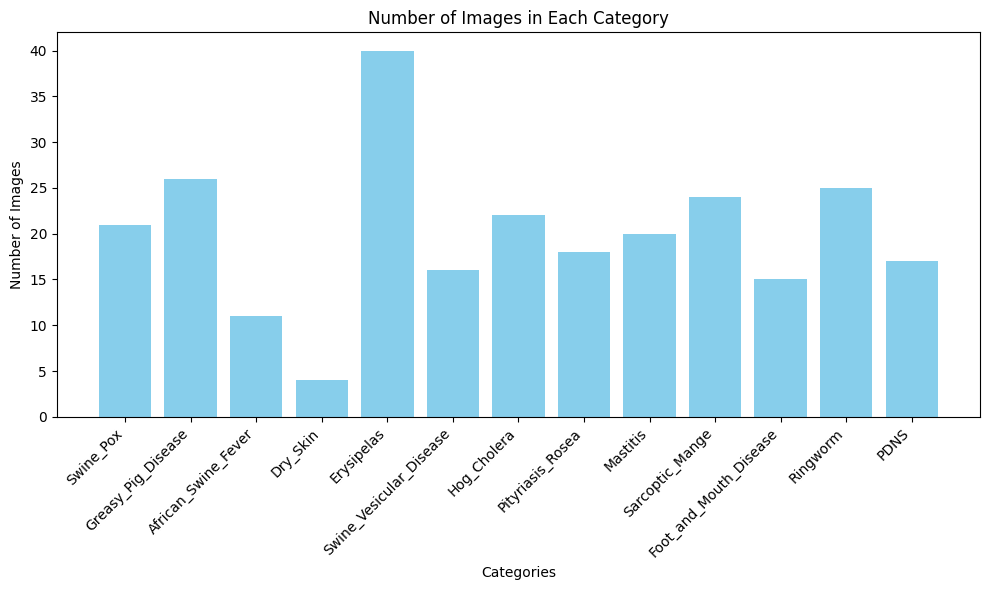

In [5]:
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

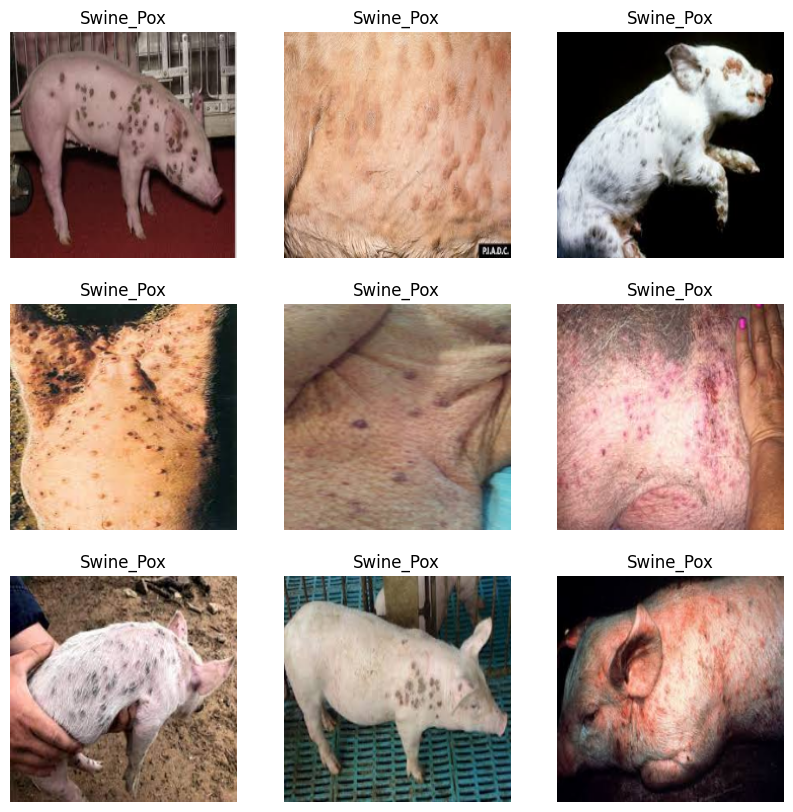

In [6]:
# Visualize cropped images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(labels[i])
    plt.axis('off')
plt.show()

In [7]:
# Step 2: Extract Features using InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)
preprocessed_images = preprocess_input(images)
features = model.predict(preprocessed_images)
print("Features shape:", features.shape)  # Print the shape of features
print("Features:", features)  # Print the features themselves

9/9 [==============================] - 8s 286ms/step
Features shape: (259, 2048)
Features: [[0.9118158  0.69215184 0.01511595 ... 0.06873751 0.05648698 0.9398088 ]
 [0.47455293 0.24078636 0.00853282 ... 0.2900618  0.29683906 1.5413204 ]
 [0.26316014 0.23062095 0.00870277 ... 0.21232747 0.190432   0.00760841]
 ...
 [0.29065648 0.26768684 0.04168739 ... 0.26538485 1.00828    0.88264966]
 [0.59168404 0.2507292  0.207309   ... 0.13588366 2.1043417  1.1301619 ]
 [0.15918222 0.6032094  0.46927905 ... 0.23322998 0.3151011  0.8975836 ]]


In [8]:
# X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)
# num_classes = len(np.unique(labels_encoded))
# y_train = to_categorical(y_train, num_classes)
# y_test = to_categorical(y_test, num_classes)

# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


In [9]:
y_test

array([ 2,  4, 11,  2,  5, 12,  3,  9,  5,  3,  2,  4,  7,  2,  4, 12, 11,
        4,  2,  0,  4, 10,  3, 10,  6, 11,  5,  9,  9,  8, 11,  8,  2, 10,
       11, 12,  1,  5,  2,  4,  2, 11,  8,  9, 10,  6,  7, 10, 10,  2,  6,
       11])

In [10]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of X_val:", X_val.shape)

Shape of X_train: (155, 2048)
Shape of X_test: (52, 2048)
Shape of X_val: (52, 2048)


In [11]:
# Convert labels to one-hot encoding
num_classes = len(np.unique(labels_encoded))
y_train_one_hot = to_categorical(y_train, num_classes)
y_val_one_hot = to_categorical(y_val, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)

In [12]:
# Define LSTM model
lstm_model = Sequential([
    LSTM(units=128, input_shape=(1, features.shape[1])),  # LSTM layer with 128 units
    Dense(num_classes, activation='softmax')  # Output layer with softmax activation
])

In [13]:
# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with validation data
history = lstm_model.fit(
    np.expand_dims(X_train, axis=1), y_train_one_hot,
    validation_data=(np.expand_dims(X_val, axis=1), y_val_one_hot),
    epochs=10, batch_size=32, verbose=1
)

Epoch 1/10


I0000 00:00:1708827755.689044     929 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 [==============================] - 3s 146ms/step - loss: 2.5175 - accuracy: 0.1742 - val_loss: 2.4625 - val_accuracy: 0.1731
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 1.9832 - accuracy: 0.4774 - val_loss: 2.3721 - val_accuracy: 0.2115
Epoch 3/10
5/5 [==============================] - 0s 11ms/step - loss: 1.6030 - accuracy: 0.6710 - val_loss: 2.3375 - val_accuracy: 0.2885
Epoch 4/10
5/5 [==============================] - 0s 11ms/step - loss: 1.2524 - accuracy: 0.7419 - val_loss: 2.2815 - val_accuracy: 0.3462
Epoch 5/10
5/5 [==============================] - 0s 11ms/step - loss: 0.9684 - accuracy: 0.8452 - val_loss: 2.1997 - val_accuracy: 0.3462
Epoch 6/10
5/5 [==============================] - 0s 11ms/step - loss: 0.7444 - accuracy: 0.9097 - val_loss: 2.1761 - val_accuracy: 0.3654
Epoch 7/10
5/5 [==============================] - 0s 11ms/step - loss: 0.5669 - accuracy: 0.9226 - val_loss: 2.1111 - val_accuracy: 0.4038
Epoch 8/10
5/5 [=====================

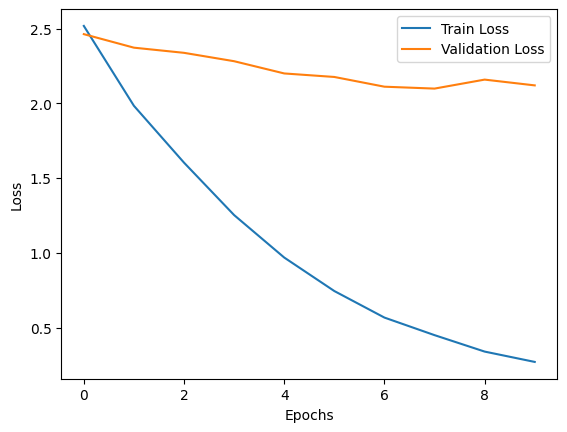

In [14]:
# Plot train and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

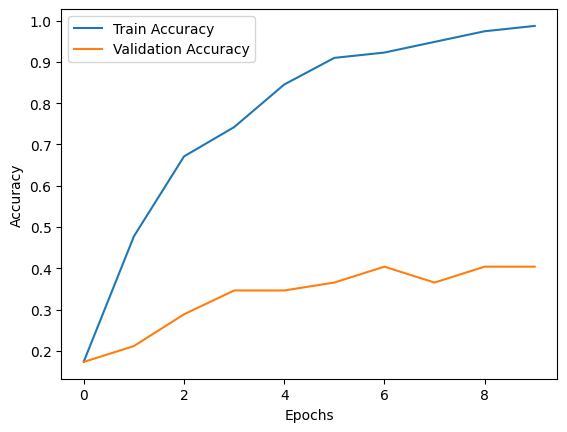

In [15]:
# Plot train and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
# Evaluate the model on test data
loss, accuracy = lstm_model.evaluate(np.expand_dims(X_test, axis=1), y_test_one_hot)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

2/2 [==============================] - 0s 5ms/step - loss: 2.2052 - accuracy: 0.3654
Test Loss: 2.2051682472229004
Test Accuracy: 0.36538460850715637


In [17]:
# from tensorflow.keras.layers import Reshape

# # Reshape features to add a time step dimension
# X_train_reshaped = np.expand_dims(X_train, axis=1)
# X_test_reshaped = np.expand_dims(X_test, axis=1)

# # Define LSTM model
# lstm_model = Sequential([
#     LSTM(units=128, input_shape=(1, features.shape[1])),  # LSTM layer with 128 units
#     Dense(num_classes, activation='softmax')  # Output layer with softmax activation
# ])

# # Compile the model
# lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# history = lstm_model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=10, batch_size=32, verbose=1)

# # Evaluate the model
# loss, accuracy = lstm_model.evaluate(X_test_reshaped, y_test)
# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)